# Using Pypbomb

Let's go over some quick examples of how you might use pypbomb to design a detonation tube for your research.

In [1]:
from itertools import product
import warnings

import cantera as ct
import numpy as np
import pandas as pd
import pint
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator

from pypbomb import tube

ureg = pint.UnitRegistry()
quant = ureg.Quantity

sns.set_context("notebook")
sns.set_style("white")

## Determine tube size and operating limits

First let us pick a mixture of stoichiometric propane/air. For this example we will use ``gri30.cti`` as the mechanism of choice for our Cantera calculations.

In [2]:
fuel = "C3H8"
oxidizer = "O2:1 N2:3.76"
material = "316L"
mechanism = "gri30.cti"
gas = ct.Solution(mechanism)
gas.set_equivalence_ratio(1, fuel, oxidizer)

Next, let's consider 316L since it's a commonly used stainless steel.

In [3]:
material = "316L"

At this point we should probably figure out which schedules are available across all of the potential pipe sizes that we'd like to consider.

In [4]:
potential_sizes = ["1", "3", "4", "6"]
common_sizes = set(tube.Tube.get_available_pipe_schedules(potential_sizes[0]))
for size in potential_sizes[1:]:
    common_sizes.intersection_update(
        set(tube.Tube.get_available_pipe_schedules(size))
    )
common_sizes

{'10', '10s', '160', '40', '40s', '5', '5s', '80', '80s', 'XXH'}

Given these options, let's choose schedules 40, 80, 120, and XXH for consideration.

In [5]:
potential_schedules = ["40", "80", "XXH"]

Let's also look at a range of operating temperatures, in case we need to preheat our tube.

In [6]:
initial_temperatures = quant(
    np.linspace(20, 400, 6),
    "degC"
)

Now let's figure out what we can do with each combination of pipe size, pipe schedule, and initial temperature. The steps we will use for each combination are:

1. look up the tube dimensions,
2. look up the maximum allowable stress,
3. calculate the corresponding maximum pressure,
4. look up the elastic modulus, density, and Poisson ratio of our tube material, and
5. calculate the maximum safe initial pressure that we can test at.

Note that we are setting ``multiprocessing=False``, since multiprocessing can cause unexpected misbehavior when run from within a jupyter notebook.

In [7]:
calculate_results = False
results_file = "tube_size_results.h5"

combinations = list(
    product(
        potential_schedules,
        potential_sizes,
        initial_temperatures
    )
)
if calculate_results:
    results = pd.DataFrame(
        columns=[
            "schedule",
            "size",
            "max initial pressure (psi)",
            "initial temperature (F)",
            "tube_temp",
            "max_pressure",
            "DLF",
        ]
    )
    for i, (schedule, size, initial_temperature) in enumerate(combinations):
        dims = tube.Tube.get_dimensions(
            size,
            schedule,
            unit_registry=ureg
        )
        max_stress = tube.Tube.calculate_max_stress(
            initial_temperature,
            material,
            welded=False,
            unit_registry=ureg
        )
        max_pressure = tube.Tube.calculate_max_pressure(
            dims["inner_diameter"],
            dims["outer_diameter"],
            max_stress
        )
        elastic_modulus = tube.Tube.get_elastic_modulus(material, ureg)
        density = tube.Tube.get_density(material, ureg)
        poisson = tube.Tube.get_poisson(material)
        initial_pressure, dlf = tube.Tube.calculate_max_initial_pressure(
            dims["inner_diameter"],
            dims["outer_diameter"],
            initial_temperature,
            gas.mole_fraction_dict(),
            mechanism,
            max_pressure.to("Pa"),
            elastic_modulus,
            density,
            poisson,
            use_multiprocessing=False,
            return_dlf=True
        )

        current_results = pd.Series(dtype="object")
        current_results["schedule"] = schedule
        current_results["size"] = size
        current_results["max initial pressure (psi)"] = \
        initial_pressure.to("psi").magnitude
        current_results["initial temperature (F)"] = \
            initial_temperature.to("degF").magnitude
        current_results["tube_temp"] = initial_temperature
        current_results["max_pressure"] = max_pressure
        current_results["inner_diameter"] = dims["inner_diameter"]
        current_results["DLF"] = dlf
        results = pd.concat(
            (results, current_results.to_frame().T),
            ignore_index=True
        )
    
    float_keys = [
        "max initial pressure (psi)",
        "initial temperature (F)",
        "DLF"
    ]
    results[float_keys] = results[float_keys].astype(float)
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        with pd.HDFStore(results_file, "w") as store:
            store.put("data", results)

else:
    with pd.HDFStore(results_file, "r") as store:
        results = store.data
        

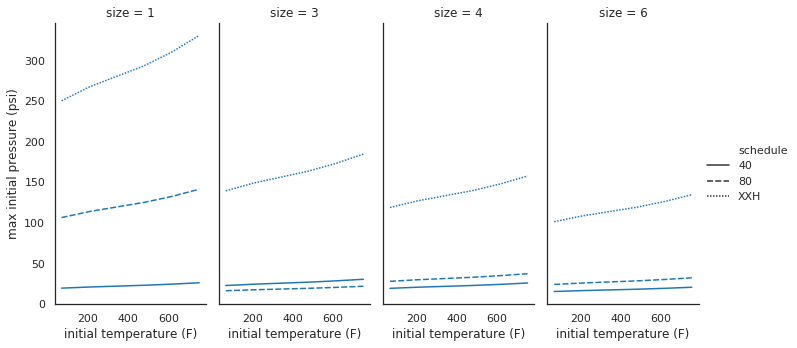

In [8]:
sns.relplot(
    x="initial temperature (F)",
    y="max initial pressure (psi)",
    col="size",
    style="schedule",
    kind="line",
    data=results,
    aspect=0.5
)
sns.despine()

Here we have operating limits for our mixture over varying initial temperatures across three schedules and four pipe sizes. At NPS 3 something interesting happens: schedule 80 pipe has a lower initial pressure than schedule 40 pipe. This is caused by the dynamic load factor, as shown below.

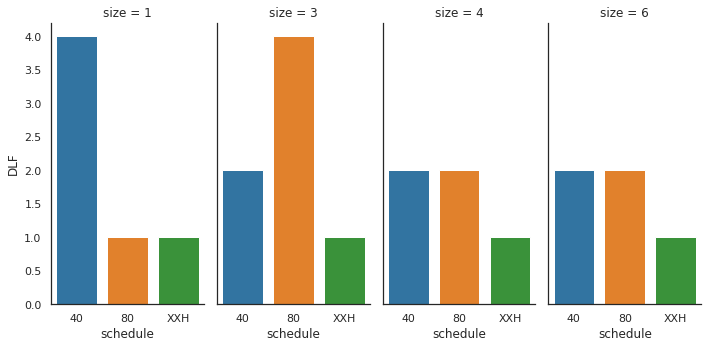

In [9]:
sns.catplot(
    x="schedule",
    y="DLF",
    col="size",
    kind="bar",
    data=results,
    aspect=0.5
);

Let us select NPS 6 schedule 80 pipe for the main section of our detonation tube, in order to maximize the size of the viewing windows and allow for a wider range of cell sizes to be captured by our camera.

In [10]:
nps_main = "6"
schedule_main = "80"
results_main = results[
    (results["size"] == nps_main) &
    (results["schedule"] == schedule_main)
].copy()
results_original = results_main[
    ["max initial pressure (psi)",
     "initial temperature (F)"]].astype(float)
results_main.drop(
    ["max initial pressure (psi)",
     "initial temperature (F)"],
    axis=1,
    inplace=True
)
results_main

,schedule,size,tube_temp,max_pressure,DLF,inner_diameter
42,80,6,20.0 degree_Celsius,2.1903439367027286 kip_per_square_inch,2.0,5.761 inch
43,80,6,96.0 degree_Celsius,1.846139060229291 kip_per_square_inch,2.0,5.761 inch
44,80,6,172.0 degree_Celsius,1.5963561440335863 kip_per_square_inch,2.0,5.761 inch
45,80,6,248.0 degree_Celsius,1.4192312611012432 kip_per_square_inch,2.0,5.761 inch
46,80,6,324.0 degree_Celsius,1.3029337639270142 kip_per_square_inch,2.0,5.761 inch
47,80,6,400.0 degree_Celsius,1.2265926045535283 kip_per_square_inch,2.0,5.761 inch


With operational limits for the main detonation section out of the way, let's consider a smaller, parallel tube with an internal fan to facilitate reactant mixing. Let's also try to use schedule 40, since it is cheaper and more readily available than schedule 80. An important thing to check here is that the mixing section can handle at least as much pressure as the main section.

In [11]:
nps_mix = "1"
schedule_mix = "40"
results_mix = results[
    (results["size"] == nps_mix) &
    (results["schedule"] == schedule_mix)
].drop(
    ["max initial pressure (psi)",
     "initial temperature (F)",
     "inner_diameter"],
    axis=1
)
results_mix["max_main_pressure"] = results_main["max_pressure"].values
results_mix["safe"] = (results_mix["max_pressure"] > 
                       results_mix["max_main_pressure"])
if all(results_mix["safe"]):
    print("Mix tube is safe :)")
else:
    print("Mix tube is unsafe :(")
results_mix

Mix tube is safe :)


,schedule,size,tube_temp,max_pressure,DLF,max_main_pressure,safe
0,40,1,20.0 degree_Celsius,3.5331641285956006 kip_per_square_inch,4.0,2.1903439367027286 kip_per_square_inch,True
1,40,1,96.0 degree_Celsius,2.9779397631133677 kip_per_square_inch,4.0,1.846139060229291 kip_per_square_inch,True
2,40,1,172.0 degree_Celsius,2.5750240270727587 kip_per_square_inch,4.0,1.5963561440335863 kip_per_square_inch,True
3,40,1,248.0 degree_Celsius,2.289310321489002 kip_per_square_inch,4.0,1.4192312611012432 kip_per_square_inch,True
4,40,1,324.0 degree_Celsius,2.1017150592216587 kip_per_square_inch,4.0,1.3029337639270142 kip_per_square_inch,True
5,40,1,400.0 degree_Celsius,1.9785719120135372 kip_per_square_inch,4.0,1.2265926045535283 kip_per_square_inch,True


## Select proper flanges

Now we need to know what class of flanges each of our sections require. For this we will use the maximum system pressure, which is the pressure behind the reflected detonation wave at the maximum allowable initial pressure.

### Main section

In [12]:
results_main["flange class"] = results_main.apply(
    lambda x: tube.Flange.get_class(
        x["max_pressure"],
        x["tube_temp"],
        material,
        ureg
    ),
    axis=1
)
results_main["flange class"].max()

'1500'

### Mixing section

In [13]:
results_mix["flange class"] = results_mix.apply(
    lambda x: tube.Flange.get_class(
        x["max_main_pressure"],
        x["tube_temp"],
        material,
        ureg
    ),
    axis=1
)
results_mix["flange class"].max()

'1500'

## Determine window dimensions and bolt pattern

### Window Dimensions

Since our main tube is NPS-6 schedule 80 pipe, the inner diameter is 5.76 inches. Therefore, let's design a viewing section with a visible window height of 5.75 inches. First, let's figure out how thick a fused quartz window needs to be in order to have a safety factor of 4. Also, let's try to constrain ourselves to keeping the window thickness under 1 inch if we can.

In [14]:
window_height = quant(5.75, "in")
window_lengths = np.linspace(0.25, 7, 100)
window_thicknesses = tube.Window.minimum_thickness(
    length=window_height,
    width=quant(window_lengths, "in"),
    safety_factor=4,
    pressure=results_main["max_pressure"].max(),
    rupture_modulus=(197.9, "MPa"),
    unit_registry=ureg
).to("in").magnitude

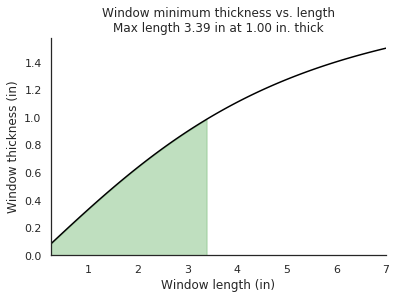

In [15]:
max_desired_thickness = 1  # inch
plt.plot(window_lengths, window_thicknesses, "k")
plt.fill_between(
    window_lengths[window_thicknesses <= max_desired_thickness],
    window_thicknesses[window_thicknesses <= max_desired_thickness], 
    0,
    color="g",
    alpha=0.25,
    zorder=-1
)
plt.xlim([window_lengths.min(), window_lengths.max()])
plt.ylim([0, plt.ylim()[1]])
plt.xlabel("Window length (in)")
plt.ylabel("Window thickness (in)")
plt.title(
    "Window minimum thickness vs. length\n"
    "Max length {:3.2f} in at {:3.2f} in. thick".format(
        window_lengths[window_thicknesses <= max_desired_thickness].max(),
        max_desired_thickness
    )
)
sns.despine()

let's go with a 2.25 inch wide window (due to camera limitations), and stick to 1 inch thick. what's the safety factor?

In [16]:
window_length = quant(2.25, "in")
tube.Window.safety_factor(
    window_length,
    window_height,
    quant(1, "in"),
    pressure=results_main["max_pressure"].max(),
    rupture_modulus=quant(197.9, "MPa"),    
)

7.95962038236468

Nice.

### Bolt pattern

Now let's see how many 1/4-28 grade 8 bolts we need to clamp our window in place if we can tap them 1/2 inch into the viewing section plate.

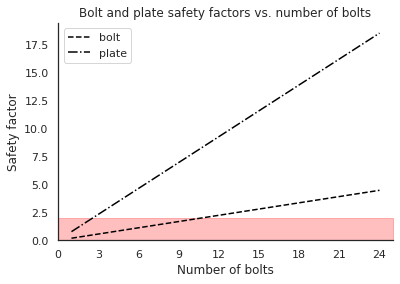

In [17]:
num_bolts = np.array(range(1, 25))
bolt_safety_factors = tube.Bolt.calculate_safety_factors(
    max_pressure=results_main["max_pressure"].max(),
    window_area = window_length * window_height,
    num_bolts=num_bolts,
    thread_size="1/4-28",
    thread_class="2",
    bolt_max_tensile=(150, "kpsi"),  # grade 8
    plate_max_tensile=(485, "MPa"),  # 316L,
    engagement_length=(0.5, "in"),
    unit_registry=ureg
)

fig, ax = plt.subplots()
ax.plot(
    num_bolts, 
    bolt_safety_factors["bolt"],
    "k--",
    label="bolt"
)
ax.plot(
    num_bolts, 
    bolt_safety_factors["plate"],
    "k-.",
    label="plate"
)
    
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend()
ax.set_ylim([0, ax.get_ylim()[1]])
ax.set_xlim([num_bolts.min()-1, num_bolts.max()+1])
ax.set_xlabel("Number of bolts")
ax.set_ylabel("Safety factor")
ax.set_title("Bolt and plate safety factors vs. number of bolts")
ax.fill_between(
    ax.get_xlim(), 
    2,
    zorder=-1,
    color="r",
    alpha=0.25,
)
sns.despine()

For a safety factor of 2.5, we will need a minimum of 12 bolts. Another important thing to pay attention to: The bolt safety factor is less than the plate safety factor. This is desirable; bolts are much cheaper to replace than a detonation tube, particularly when the part of the tube in question is machined from a very large and expensive piece of stainless steel!

## Estimate DDT length

Now let's estimate how long it will take a deflagration ignited at one end of the tube to transition into a detonation. The `calculate_blockage_diameter` and `calculate_blockage_ratio` functions included in `tube.DDT` are for a Shchelkin spiral. This is not the only blockage pattern that can be used, however if you want to use an arbitrary blockage you will have to handle blockage ratio calculations on your own. That being said, the `DDT.calculate_run_up` function accepts arguments of blockage ratio and tube diameter, meaning that its only geometric assumption is a circular chamber cross-section.

In [18]:
main_id = results_main["inner_diameter"].iloc[0]
target_blockage_diameter = tube.DDT.calculate_blockage_diameter(
    main_id,
    0.45,
    unit_registry=ureg
)
print("Target blockage diameter: {:3.2f}".format(target_blockage_diameter))

Target blockage diameter: 0.74 inch


In [19]:
blockage_actual = tube.DDT.calculate_blockage_ratio(
    main_id,
    (0.75, "in"),
    unit_registry=ureg
)
print("Actual blockage ratio: {:4.1f}%".format(blockage_actual*100))

Actual blockage ratio: 45.3%


In [20]:
runup = tube.DDT.calculate_run_up(
    blockage_actual,
    main_id,
    (70, "degF"),
    (1, "atm"),
    gas.mole_fraction_dict(),
    mechanism,
    unit_registry=ureg
)
print("Runup distance: {:1.2f}".format(runup.to("millifurlong")))

Runup distance: 6.14 millifurlong


Of course, since this package makes use of `pint`, you may use whatever ridiculous units you want for inputs and outputs.

## Find safe operation limits for a new mixture

Finally, since the dynamic load factor is a function of wave speed as well as the tube's geometry and material properties, the operational limits of your tube may change from mixture to mixture. Let's take a look at what would happen to our safe operation limits for this tube if we decided to pack it with hydrogen and oxygen instead of propane and air.

In [21]:
results_file = "second_mixture_results.h5"

calculate_results = False
new_fuel = "H2"
new_oxidizer = "O2"
gas2 = ct.Solution(mechanism)
gas2.set_equivalence_ratio(1, new_fuel, new_oxidizer)

if calculate_results:
    results = pd.DataFrame(
        columns=[
            "max initial pressure (psi)",
            "initial temperature (F)",
        ]
    )
    for i, initial_temperature in enumerate(initial_temperatures):
        dims = tube.Tube.get_dimensions(
            nps_main,
            schedule_main,
            unit_registry=ureg
        )
        max_stress = tube.Tube.calculate_max_stress(
            initial_temperature,
            material,
            welded=False,
            unit_registry=ureg
        )
        max_pressure = tube.Tube.calculate_max_pressure(
            dims["inner_diameter"],
            dims["outer_diameter"],
            max_stress
        )
        elastic_modulus = tube.Tube.get_elastic_modulus(material, ureg)
        density = tube.Tube.get_density(material, ureg)
        poisson = tube.Tube.get_poisson(material)
        initial_pressure = tube.Tube.calculate_max_initial_pressure(
            dims["inner_diameter"],
            dims["outer_diameter"],
            initial_temperature,
            gas2.mole_fraction_dict(),
            mechanism,
            max_pressure.to("Pa"),
            elastic_modulus,
            density,
            poisson,
            use_multiprocessing=False
        )

        current_results = pd.Series(dtype="object")
        current_results["max initial pressure (psi)"] = \
        initial_pressure.to("psi").magnitude
        current_results["initial temperature (F)"] = \
            initial_temperature.to("degF").magnitude
        results = pd.concat(
            (results, current_results.to_frame().T),
            ignore_index=True
        )
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        with pd.HDFStore(results_file, "w") as store:
            store.put("data", results)

else:
    with pd.HDFStore(results_file, "r") as store:
        results = store.data

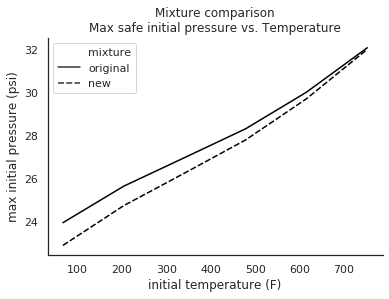

In [22]:
results_original["mixture"] = "original"
results["mixture"] = "new"
sns.lineplot(
    x="initial temperature (F)",
    y="max initial pressure (psi)",
    data=pd.concat((results_original, results)),
    style="mixture",
    color="k",
)
plt.title("Mixture comparison\nMax safe initial pressure vs. Temperature")
sns.despine()